=== SINDy model for Hopf (FD derivatives) ===
dx/dt = -0.0304358 + 1.01807*x - 0.978142*y + 0.0304335*x^2 + 0.030395*y^2 - 1.01806*x^3 - 0.0218272*x^2 y - 1.01804*x y^2 - 0.0218882*y^3
dy/dt = 0.999998*x + 0.999262*y - 0.999276*x^2 y - 0.99927*y^3


(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'Hopf Trajectory Error $\\|x_{\\mathrm{true}} - x_{\\mathrm{SINDy}}\\|$'}, xlabel='t', ylabel='error'>)

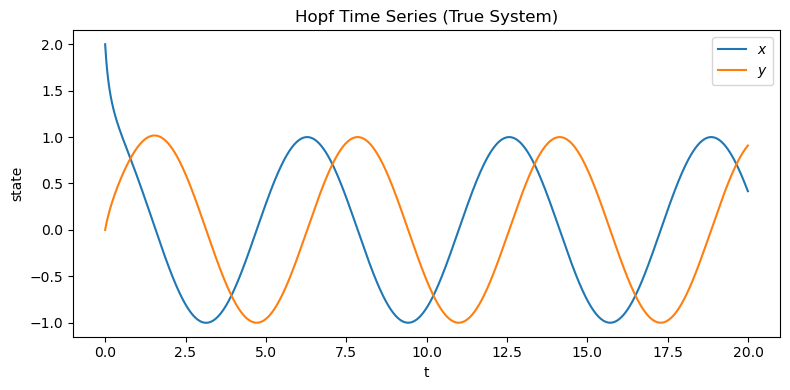

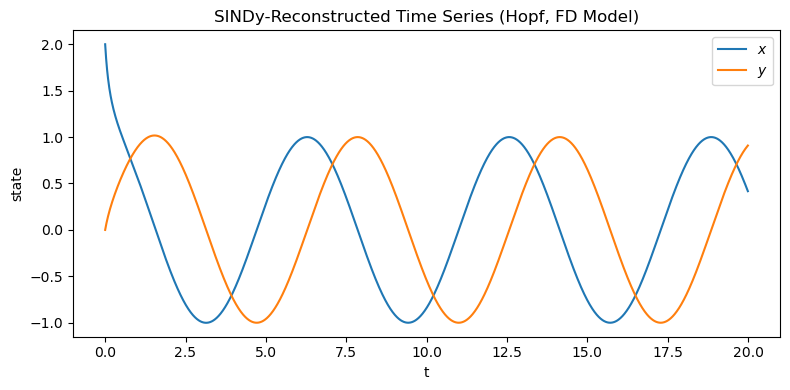

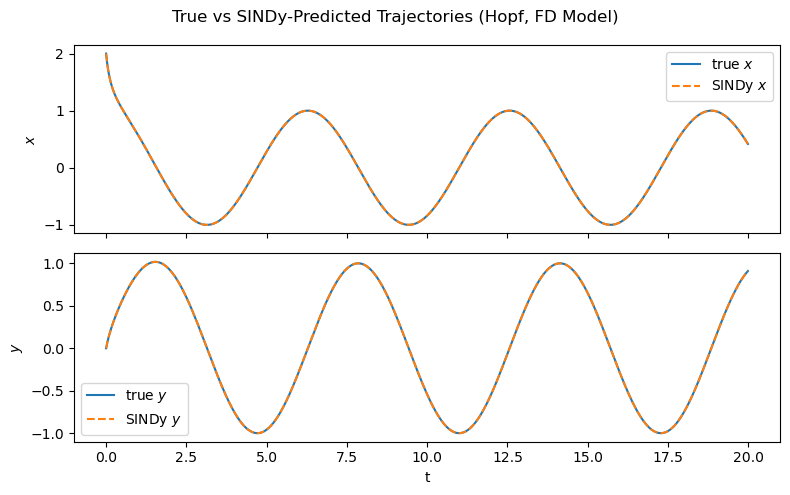

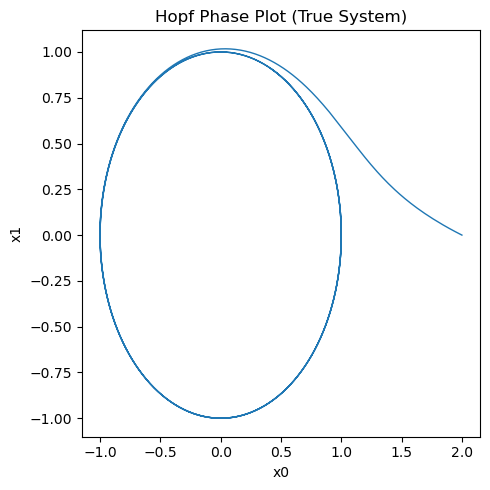

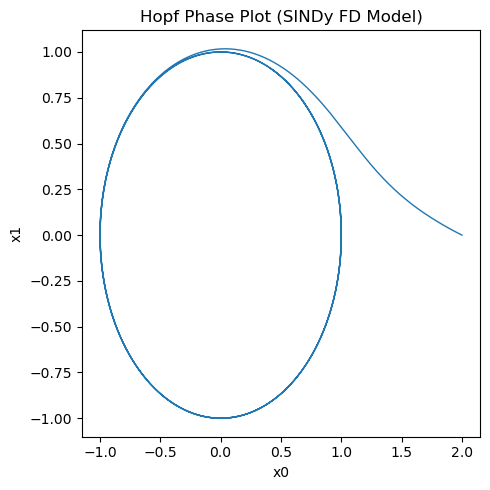

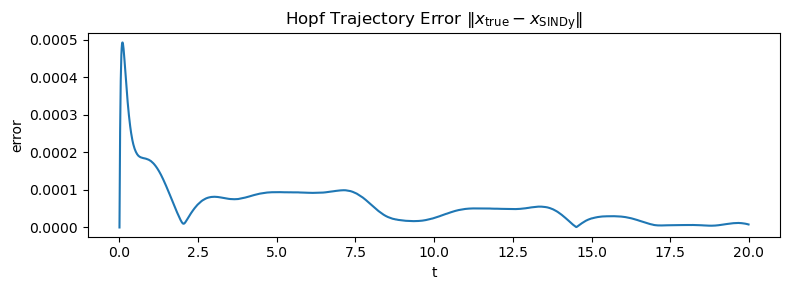

In [1]:
import sys, os

sys.path.append(os.path.join("..", "src"))

import numpy as np
import jax.numpy as jnp

from systems import HopfDefinition
from sindy_core import SINDyModel, SINDyConfig
from derivatives import finite_difference_derivative
from plotting import (
    plot_time_series,
    plot_phase,
    plot_3d,  # not needed for 2D but available
    plot_time_series_comparison,
    plot_3d_comparison,  # also optional for Hopf
    plot_error_time_series,
)


# ---------- 1. Hopf simulation (true system) ----------

hopf_params = {"mu": 1.0, "omega": 1.0}
hopf_x0 = jnp.array([2.0, 0.0])

hopf = HopfDefinition(
    parameters=hopf_params,
    x0_vector=hopf_x0,
    t0=0.0,
    tf=20.0,
    dt=0.01,
)

ts, xs = hopf.simulate()  # ts: (N,), xs: (N, 2)


# ---------- 2. Finite-difference derivatives ----------

Xdot_fd = finite_difference_derivative(ts, xs)  # (N, 2)

# crop ends for SINDy (FD boundary artifacts)
crop = slice(1, -1)
X = xs[crop, :]
Xdot = Xdot_fd[crop, :]


# ---------- 3. Fit SINDy (FD baseline for Hopf) ----------

cfg = SINDyConfig(
    poly_degree=3,  # cubic needed for the (x^2 + y^2)x terms
    include_bias=True,
    threshold=0.1,
    n_iter=10,
    post_tol=1e-2,
    var_names=("x", "y"),
)

model = SINDyModel(cfg).fit(X, Xdot)

print("=== SINDy model for Hopf (FD derivatives) ===")
model.print()


# ---------- 4. Simulate the learned SINDy model ----------

x0_true = np.asarray(xs[0, :])
xs_pred = model.simulate(x0_true, ts, method="rk4")  # (N, 2)
error_traj = np.linalg.norm(np.asarray(xs) - xs_pred, axis=1)


# ---------- 5. Plots using plotting utilities ----------

labels = [r"$x$", r"$y$"]

# (a) True Hopf time series
plot_time_series(
    ts,
    xs,
    labels=labels,
    title="Hopf Time Series (True System)",
)

# (b) SINDy-predicted time series
plot_time_series(
    ts,
    xs_pred,
    labels=labels,
    title="SINDy-Reconstructed Time Series (Hopf, FD Model)",
)

# (c) Overlay comparison
plot_time_series_comparison(
    ts,
    xs,
    xs_pred,
    labels=labels,
    title="True vs SINDy-Predicted Trajectories (Hopf, FD Model)",
)

# (d) Phase portrait (true and SINDy, same plane x0–x1)
plot_phase(xs, i=0, j=1, title="Hopf Phase Plot (True System)")
plot_phase(xs_pred, i=0, j=1, title="Hopf Phase Plot (SINDy FD Model)")

# (e) Trajectory error over time
plot_error_time_series(
    ts,
    error_traj,
    title=r"Hopf Trajectory Error $\|x_{\mathrm{true}} - x_{\mathrm{SINDy}}\|$",
)

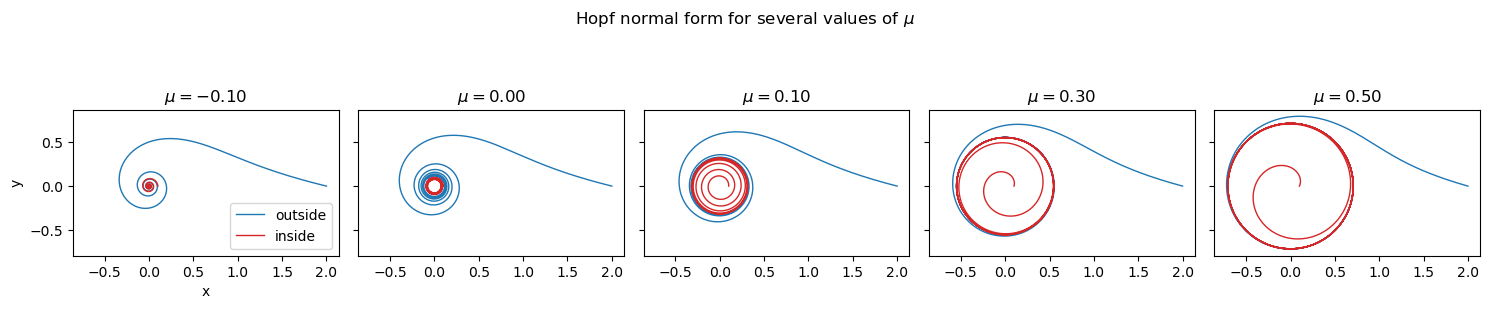

In [4]:
import sys, os

sys.path.append(os.path.join("..", "src"))

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from systems import HopfDefinition

omega = 1.0
A = 1.0  # only needed if you added it to HopfDefinition; otherwise omit

# Choose a few representative μ values
mu_values = [-0.1, 0.0, 0.1, 0.3, 0.5]

t0, tf, dt = 0.0, 40.0, 0.01

# One initial condition "outside" and one "inside" the limit cycle
x0_out = jnp.array([2.0, 0.0])
x0_in = jnp.array([0.1, 0.0])


def simulate_hopf(mu, x0):
    params = {"mu": float(mu), "omega": omega}
    # if your HopfDefinition takes A as well:
    # params = {"mu": float(mu), "omega": omega, "A": A}

    hopf = HopfDefinition(
        parameters=params,
        x0_vector=x0,
        t0=t0,
        tf=tf,
        dt=dt,
    )
    ts, xs = hopf.simulate()
    return np.array(ts), np.array(xs)


fig, axes = plt.subplots(
    1, len(mu_values), figsize=(3 * len(mu_values), 3), sharex=True, sharey=True
)

for ax, mu in zip(axes, mu_values):
    # outside traj (blue)
    _, xs_out = simulate_hopf(mu, x0_out)
    ax.plot(
        xs_out[:, 0], xs_out[:, 1], color="C0", linewidth=1.0, label="outside"
    )

    # inside traj (red)
    _, xs_in = simulate_hopf(mu, x0_in)
    ax.plot(xs_in[:, 0], xs_in[:, 1], color="C3", linewidth=1.0, label="inside")

    ax.set_title(r"$\mu = {:.2f}$".format(mu))
    ax.set_aspect("equal", adjustable="box")

axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].legend(loc="best")

fig.suptitle("Hopf normal form for several values of $\\mu$", y=1.02)
fig.tight_layout()
plt.show()